In [ ]:
import matplotlib.pyplot as plt # pyright: ignore[reportMissingModuleSource]
import pandas as pd # pyright: ignore[reportMissingModuleSource]
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re
from sklearn.metrics.pairwise import cosine_similarity
import requests
import io
from nltk.tokenize import word_tokenize
import tarfile
from gensim.models import FastText
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer


nltk.download("stopwords")
nltk.download('punkt_tab')

stop_words = set(stopwords.words("english"))

%cd ..

/home/kalisto/Documents/info_search_spbu_2025/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/kalisto/Documents/info_search_spbu_2025


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kalisto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/kalisto/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
data = pd.read_json("data/arxiv_attention_is_all_you_need_data.json")
data["published"] = pd.to_datetime(data["published"])
data["updated"] = pd.to_datetime(data["updated"])
data.info()
df = data.copy()
df["id"] = data["id"].str[21:]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2305 entries, 0 to 2304
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   id         2305 non-null   object             
 1   title      2305 non-null   object             
 2   summary    2305 non-null   object             
 3   published  2305 non-null   datetime64[ns, UTC]
 4   updated    2305 non-null   datetime64[ns, UTC]
 5   authors    2305 non-null   object             
dtypes: datetime64[ns, UTC](2), object(4)
memory usage: 108.2+ KB


In [3]:
data_attn = pd.read_json("data/arxiv_attention_is_all_you_need.json")
data_attn["published"] = pd.to_datetime(data_attn["published"])
data_attn["updated"] = pd.to_datetime(data_attn["updated"])
data_attn.info()
df_attn = data_attn.copy()
df_attn["id"] = df_attn["id"].str[21:]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   id         1 non-null      object             
 1   title      1 non-null      object             
 2   summary    1 non-null      object             
 3   published  1 non-null      datetime64[ns, UTC]
 4   updated    1 non-null      datetime64[ns, UTC]
 5   authors    1 non-null      object             
dtypes: datetime64[ns, UTC](2), object(4)
memory usage: 180.0+ bytes


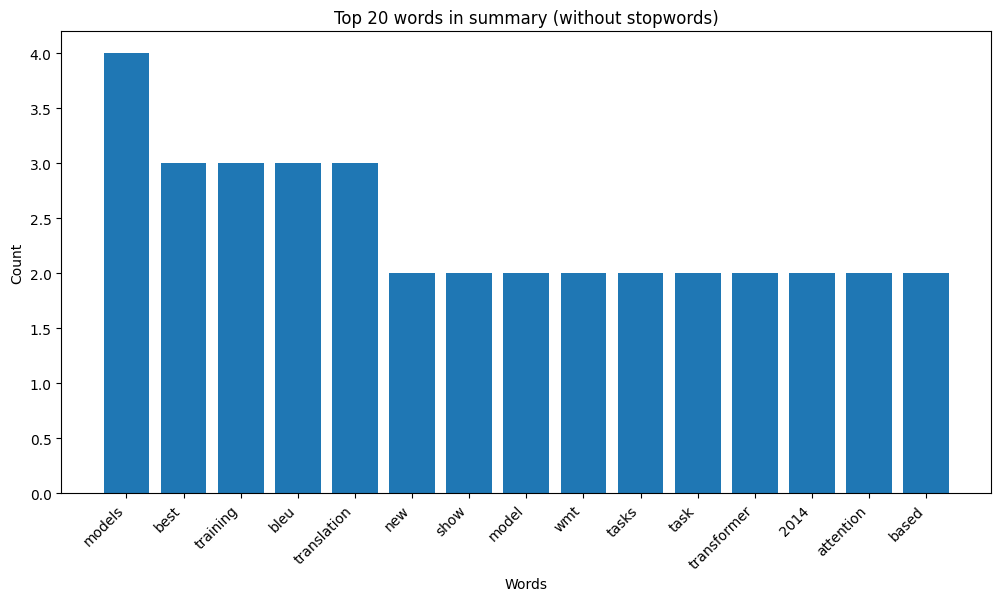

In [4]:
series_ref = df_attn[df_attn['id'] == '1706.03762v7'].iloc[0]
series_ref = series_ref.replace({r'[":/*#$@,.()]': ''}, regex=True)
series_ref = series_ref.replace({r'[\n]': ' '}, regex=True)
series_ref = series_ref.str.replace(r'http\S+|https\S+|[,.\n]', '', regex=True)
series_ref = series_ref.str.lower()
stop_words = set(stopwords.words("english"))

text = series_ref["summary"]
words = [w for w in text.split() if w not in stop_words]

word_counts = Counter(words)
df_words = pd.DataFrame(word_counts.items(), columns=["word", "count"]).sort_values(by="count", ascending=False)

top_n = 15
top_words = df_words.head(top_n)

plt.figure(figsize=(12,6))
plt.bar(top_words["word"], top_words["count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Words")
plt.ylabel("Count")
plt.title("Top 20 words in summary (without stopwords)")
plt.show()

top_words_dict = dict(zip(top_words["word"], top_words["count"]))

In [5]:
df["top_words_dict"] = pd.Series([{}]*len(df), index=df.index, dtype=object)

for idx in df.index:
    summary = df.at[idx, "summary"]
    summary = re.sub(r'http\S+|https\S+|[,.\n":/*#$@()]', '', summary)
    summary = summary.lower()
    words = [w for w in summary.split() if w not in stop_words]
    top_words = dict(Counter(words).most_common(15))
    df.at[idx, "top_words_dict"] = top_words

In [6]:
df.shape

(2305, 7)

In [7]:
series_ref

id                                                 170603762v7
title                                attention is all you need
summary      the dominant sequence transduction models are ...
published                                                  NaN
updated                                                    NaN
authors                                                    NaN
Name: 0, dtype: object

In [8]:
def get_doc_vector(text, model):
    words = text.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)


def find_similar_texts(df, series_ref, data, top_n=5, top_k=50, vector_size=100):
    sentences = [text.split() for text in df["summary"]]
    model = FastText(sentences, vector_size=vector_size, window=5, min_count=1, epochs=10)
    
    X = np.array([get_doc_vector(text, model) for text in tqdm(df["summary"], desc="Vectorizing")])
    ref_vector = get_doc_vector(series_ref["summary"], model).reshape(1, -1)
    
    similarity_matrix = cosine_similarity(ref_vector, X).flatten()
    similarities = similarity_matrix.copy()
    similarities[df.index.get_loc(series_ref.name)] = -1
    
    top_pos = similarities.argsort()[-top_k:][::-1]
    top_scores = similarities[top_pos]
    top_idx = df.index[top_pos]
    
    print(f"Reference:\nTitle: {series_ref['title']}\nLink: {data_attn.loc[data_attn.index[0], 'id']}\n")
    
    for k, (idx, score) in enumerate(zip(top_idx, top_scores), 1):
        if k <= top_n:
            print(f"{k}. Idx: {idx}\nTitle: {df.loc[idx, 'title']}\nCosine similarity: {score:.3f}\nLink: {data.loc[idx, 'id']}\n")
            
    return top_pos, top_scores, top_idx

top_pos, top_scores, top_idx = find_similar_texts(df, series_ref, data)

Vectorizing: 100%|██████████| 2305/2305 [00:00<00:00, 10865.11it/s]

Reference:
Title: attention is all you need
Link: http://arxiv.org/abs/1706.03762v7

1. Idx: 163
Title: Quantum Graph Transformer for NLP Sentiment Classification
Cosine similarity: 0.971
Link: http://arxiv.org/abs/2506.07937v1

2. Idx: 1002
Title: TreeGPT: Pure TreeFFN Encoder-Decoder Architecture for Structured
  Reasoning Without Attention Mechanisms
Cosine similarity: 0.965
Link: http://arxiv.org/abs/2509.05550v2

3. Idx: 126
Title: Weighted Transformer Network for Machine Translation
Cosine similarity: 0.963
Link: http://arxiv.org/abs/1711.02132v1

4. Idx: 199
Title: Cross-Attention Speculative Decoding
Cosine similarity: 0.959
Link: http://arxiv.org/abs/2505.24544v3

5. Idx: 1602
Title: AxFormer: Accuracy-driven Approximation of Transformers for Faster,
  Smaller and more Accurate NLP Models
Cosine similarity: 0.958
Link: http://arxiv.org/abs/2010.03688v2



In [9]:
def clean_text(raw_text:str) -> str:
    """ Remove LaTeX commands and comments """
    # Remove comments
    text = raw_text
    text = re.sub(r'%.*$', '', text, flags=re.MULTILINE)
    text = re.sub(r'[0-9]', '', text)
    
    # Remove LaTeX commands (e.g., \textbf{...}, \cite{...})
    text = re.sub(r'\\[a-zA-Z]+\{[^}]*\}', '', text)
    text = re.sub(r'\\[a-zA-Z]+\[.*?\]', '', text)
    text = re.sub(r'\\[a-zA-Z]+', '', text)
    
    # Remove special LaTeX characters
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'_', '', text)
    
    # Remove multiple spaces and newlines
    text = re.sub(r' +', ' ', text)
    text = re.sub(r'\n\n+', ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r' +', ' ', text)
    text = re.sub(r'\\', '', text)
    text = re.sub(r' +', ' ', text)
    
    text = text.lower().strip()
    
    text = ' '.join([word for word in text.split() if 2 <= len(word) <= 6])
    
    return text

def tokenize_article(raw_text:str) -> list:
    """
    Takes raw article text and returns tokenized text.
    
    Args:
        raw_text (str): Raw article text (typically LaTeX from arXiv)
    
    Returns:
        str: Space-separated tokenized words
    """
    text = raw_text
    
    text = clean_text(text)
    
    
    # Tokenize
    tokens = word_tokenize(text)
    
    return tokens

In [10]:
def process_arxiv_paper(k: int, idx, df, score: float, arxiv_url: str, is_reference: bool = False) -> list:
    """
    Process an arXiv paper: download, extract, clean, and tokenize.
    
    Args:
        k: Result number (for display)
        idx: Paper index
        df: DataFrame containing paper metadata
        score: Cosine similarity score
        arxiv_url: URL to the arXiv paper
        is_reference: If True, display as reference paper (default: False)
    """
    if is_reference:
        #print(f"Reference:\nTitle: {df.loc[idx, 'title']}\nLink: {arxiv_url}")
        pass
    else:
        #print(f"{k}. Idx: {idx}")
        #print(f"Title: {df.loc[idx, 'title']}")
        #print(f"Cosine similarity <summary>: {score:.3f}")
        #print(f"Link: {arxiv_url}")
        pass
    
    try:
        src_url = arxiv_url.replace('/abs/', '/src/')
        
        response = requests.get(src_url, timeout=30)
        response.raise_for_status()
        
        tar_file = tarfile.open(fileobj=io.BytesIO(response.content), mode='r:gz')
        
        # Find all .tex files
        tex_files = [member for member in tar_file.getmembers() if member.name.endswith('.tex')]
        
        if tex_files:
            # Extract and read all .tex files
            raw_text = ""
            for tex_file in tex_files:
                f = tar_file.extractfile(tex_file)
                raw_text += f.read().decode('utf-8', errors='ignore') + "\n"
            
            clear_text = clean_text(raw_text)
            tokenized_text = tokenize_article(raw_text)
            
            #print(clear_text)
            #print(tokenized_text)
            
            return tokenized_text
        else:
            print("No .tex file found in archive")
        
        tar_file.close()
        
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {src_url}: {e}\n")
    except tarfile.TarError as e:
        print(f"Error extracting tar file: {e}\n")
    except Exception as e:
        print(f"Error parsing content: {e}\n")

In [11]:
ref_tokens_list = process_arxiv_paper(0, series_ref.name, df, 0, data_attn["id"].iloc[0], is_reference=True)

k = 0

for idx, score in tqdm(zip(top_idx, top_scores), total=len(top_idx), desc="Processing papers"):
    k += 1
    if k < 1:
        arxiv_url = data.loc[idx, 'id']
        tokens_list = process_arxiv_paper(k, idx, df, score, arxiv_url)
    

Processing papers: 100%|██████████| 50/50 [00:00<00:00, 1416994.59it/s]


In [12]:
model = SentenceTransformer('all-mpnet-base-v2')

try:
    ref_tokens_list = process_arxiv_paper(0, series_ref.name, df, 0, data_attn["id"].iloc[0], is_reference=True)
    ref_text = ' '.join(ref_tokens_list)
    ref_embedding = model.encode(ref_text)
except Exception as e:
    print(f"Error processing reference paper: {e}")
    ref_text = ""
    ref_embedding = None

similarity_results = []
skipped_count = 0

texts_to_compare = [ref_text] if ref_text else []
metadata = []

for k, (idx, score) in enumerate(tqdm(zip(top_idx, top_scores), total=len(top_idx), desc="Processing papers"), 1):
    try:
        arxiv_url = data.loc[idx, 'id']
        tokens_list = process_arxiv_paper(k, idx, df, score, arxiv_url)
        article_text = ' '.join(tokens_list)
        
        texts_to_compare.append(article_text)
        metadata.append({
            'df_idx': idx,
            'arxiv_url': arxiv_url,
            'summary_score': score,
            'title': df.loc[idx, 'title']
        })
    except Exception as e:
        print(f"Error processing paper {idx}: {e}")
        skipped_count += 1
        continue
    
if len(texts_to_compare) > 1:
    # Вычисляем embeddings для всех текстов
    all_embeddings = model.encode(texts_to_compare)
    ref_embedding = all_embeddings[0]
    article_embeddings = all_embeddings[1:]
    
    # Вычисляем cosine similarity
    similarities = cosine_similarity([ref_embedding], article_embeddings)[0]
    for meta, sim_score in zip(metadata, similarities):
        similarity_results.append({
            **meta,
            'total_score': sim_score
        })

Processing papers:  16%|█▌        | 8/50 [00:09<01:00,  1.44s/it]

Error extracting tar file: not a gzip file

Error processing paper 852: can only join an iterable


Processing papers:  84%|████████▍ | 42/50 [00:47<00:06,  1.28it/s]

Error extracting tar file: not a gzip file

Error processing paper 910: can only join an iterable


Processing papers:  90%|█████████ | 45/50 [00:50<00:04,  1.21it/s]

Error extracting tar file: not a gzip file

Error processing paper 2257: can only join an iterable


Processing papers: 100%|██████████| 50/50 [00:55<00:00,  1.12s/it]


In [13]:
results_df = pd.DataFrame(similarity_results)
results_df = results_df.sort_values('total_score', ascending=False)
print(f"\nProcessing complete. Skipped {skipped_count} papers due to errors.")
print("Similarity Results:")
results_df.reset_index(drop=True, inplace=True)
print(results_df.drop(columns=['title']))
#results_df



Processing complete. Skipped 3 papers due to errors.
Similarity Results:
    df_idx                          arxiv_url  summary_score  total_score
0      126  http://arxiv.org/abs/1711.02132v1       0.962675     0.815051
1     2218  http://arxiv.org/abs/2110.02402v1       0.939749     0.785097
2       76  http://arxiv.org/abs/2210.00640v2       0.945411     0.784601
3      380  http://arxiv.org/abs/2209.08167v2       0.948443     0.777945
4     1172  http://arxiv.org/abs/2402.17966v3       0.946760     0.738277
5      440  http://arxiv.org/abs/2105.03824v4       0.952980     0.719494
6     1002  http://arxiv.org/abs/2509.05550v2       0.965192     0.716848
7     1602  http://arxiv.org/abs/2010.03688v2       0.958020     0.700678
8     1429  http://arxiv.org/abs/2505.22425v1       0.945306     0.685458
9      865  http://arxiv.org/abs/2009.04534v3       0.939654     0.678045
10     371  http://arxiv.org/abs/2503.00687v3       0.950440     0.675962
11    1384  http://arxiv.org/abs/2308.